## Test Temporal Fusion Transformers V3

Using device: cpu


/var/folders/31/b1v52j156gbfz83pmrnth3jc0000gn/T/ipykernel_65247/1632834104.py:88: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')


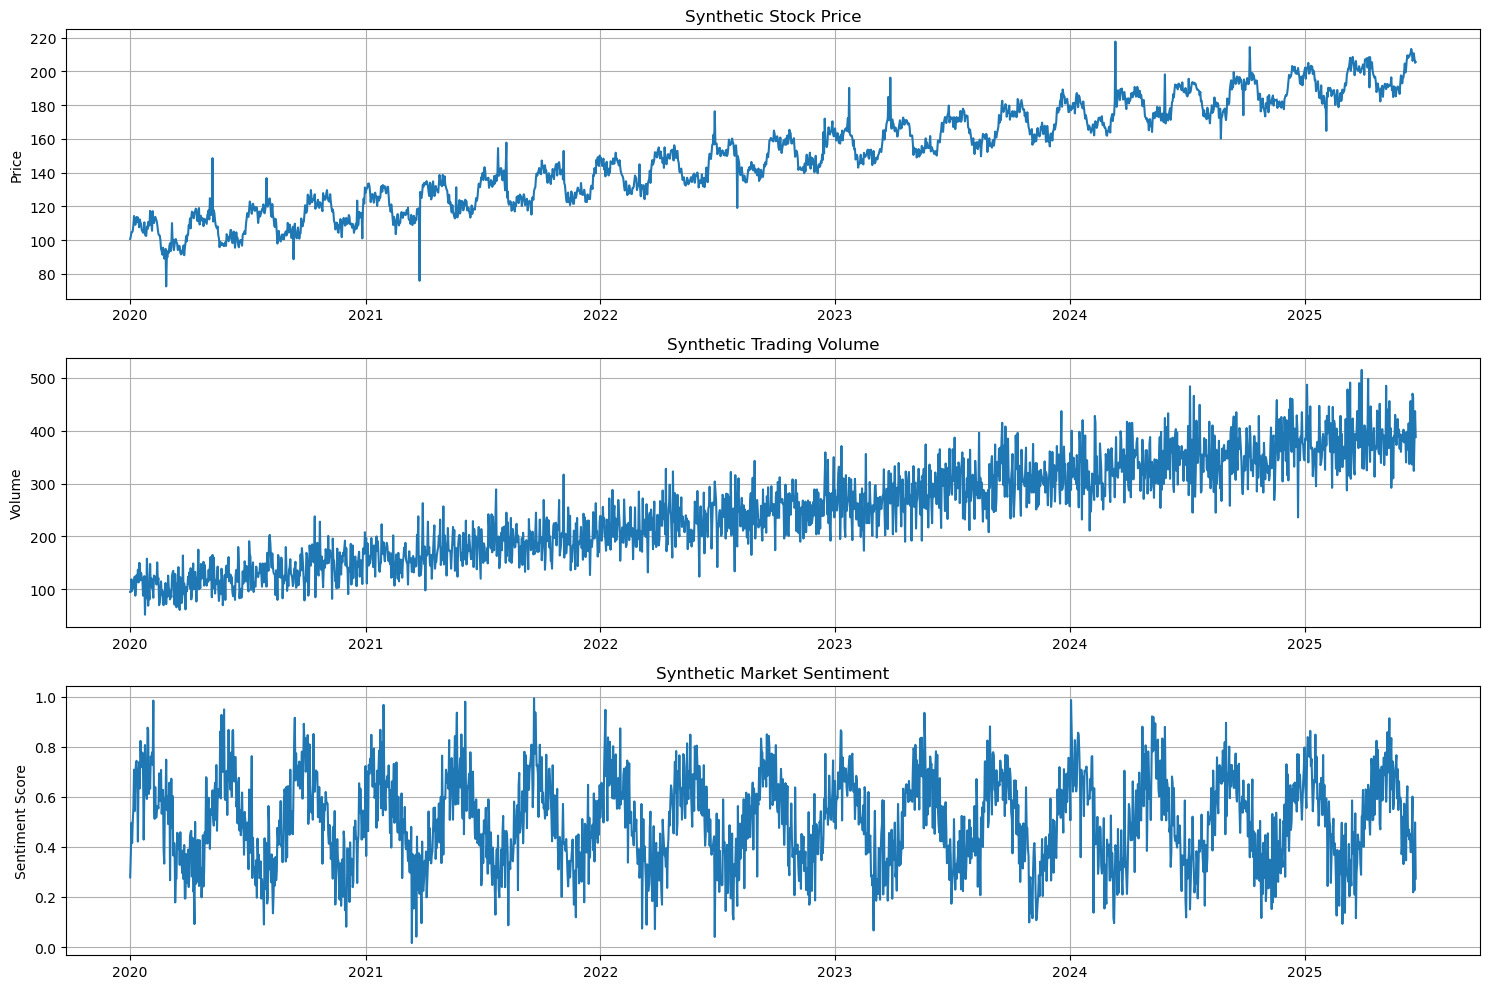

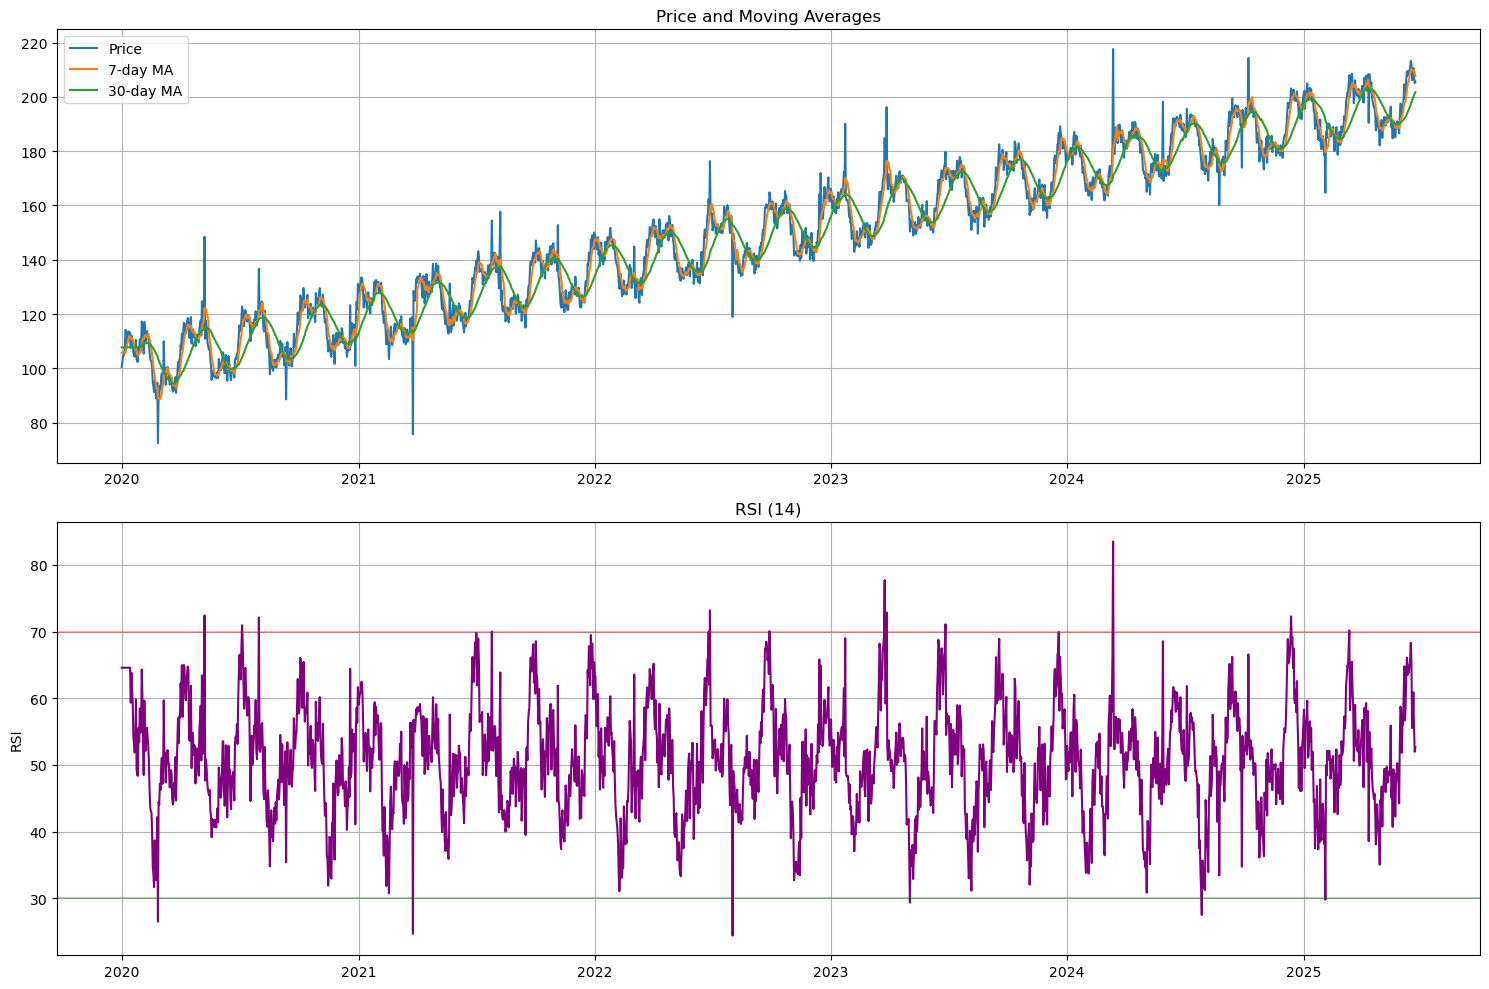

Train data shape: torch.Size([1571, 7])
Test data shape: torch.Size([393, 7])
Encoder input 0 shape: torch.Size([1571, 30, 22])
Encoder input 1 shape: torch.Size([1571, 30, 7])
Decoder input 0 shape: torch.Size([1571, 7, 22])


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from datetime import datetime, timedelta

# Import our TFT implementation
# Assuming you saved the TFT code in a file called temporal_fusion_transformer.py
from models.tft_v3 import TemporalFusionTransformer

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ====================== 1. Generate Synthetic Financial Data ======================

def generate_synthetic_financial_data(n_samples=2000, start_date="2020-01-01"):
    """Generate synthetic stock price data with trends, seasonality, and random events."""
    dates = pd.date_range(start=start_date, periods=n_samples)
    t = np.arange(n_samples)
    
    # Base price with trend
    price = 100 + 0.05 * t
    
    # Add weekly seasonality (5-day pattern)
    weekly = 2 * np.sin(2 * np.pi * t / 5)
    
    # Add monthly seasonality
    monthly = 5 * np.sin(2 * np.pi * t / 30)
    
    # Add quarterly seasonality
    quarterly = 10 * np.sin(2 * np.pi * t / 90)
    
    # Random events (occasional price jumps)
    events = np.zeros(n_samples)
    event_indices = np.random.choice(range(n_samples), size=int(n_samples * 0.03), replace=False)
    events[event_indices] = np.random.normal(0, 15, size=len(event_indices))
    
    # Daily noise
    noise = np.random.normal(0, 2, n_samples)
    
    # Combine components
    price = price + weekly + monthly + quarterly + events + noise
    
    # Ensure price is positive
    price = np.maximum(price, 1)
    
    # Create dataframe
    df = pd.DataFrame({
        'date': dates,
        'price': price,
        'day_of_week': dates.dayofweek,
        'day_of_month': dates.day,
        'month': dates.month,
        'is_quarter_end': dates.is_quarter_end.astype(int),
        'is_month_end': dates.is_month_end.astype(int),
        'year': dates.year
    })
    
    # Add technical indicators
    df['ma7'] = df['price'].rolling(window=7).mean()
    df['ma30'] = df['price'].rolling(window=30).mean()
    df['std7'] = df['price'].rolling(window=7).std()
    df['rsi'] = compute_rsi(df['price'], 14)
    
    # Add synthetic trading volume
    volume_base = price * np.random.uniform(0.8, 1.2, n_samples)
    volume_trend = 0.1 * t
    volume_noise = np.random.normal(0, price * 0.2, n_samples)
    df['volume'] = volume_base + volume_trend + volume_noise
    df['volume'] = df['volume'].astype(int)
    
    # Add synthetic sentiment data
    sentiment = 0.5 + 0.2 * np.sin(2 * np.pi * t / 120) + np.random.normal(0, 0.1, n_samples)
    df['sentiment'] = np.clip(sentiment, 0, 1)
    
    # Fill NaN values
    df = df.fillna(method='bfill')
    
    return df

def compute_rsi(prices, window=14):
    """Compute Relative Strength Index."""
    deltas = np.diff(prices)
    seed = deltas[:window+1]
    up = seed[seed >= 0].sum()/window
    down = -seed[seed < 0].sum()/window
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:window] = 100. - 100./(1. + rs)
    
    for i in range(window, len(prices)):
        delta = deltas[i-1]
        if delta > 0:
            upval = delta
            downval = 0
        else:
            upval = 0
            downval = -delta
            
        up = (up * (window - 1) + upval) / window
        down = (down * (window - 1) + downval) / window
        rs = up/down
        rsi[i] = 100. - 100./(1. + rs)
        
    return rsi

# Generate data
df = generate_synthetic_financial_data(n_samples=2000)

# Visualize the generated data
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(df['date'], df['price'])
plt.title('Synthetic Stock Price')
plt.ylabel('Price')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(df['date'], df['volume'])
plt.title('Synthetic Trading Volume')
plt.ylabel('Volume')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(df['date'], df['sentiment'])
plt.title('Synthetic Market Sentiment')
plt.ylabel('Sentiment Score')
plt.grid(True)

plt.tight_layout()
plt.show()

# Show technical indicators
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(df['date'], df['price'], label='Price')
plt.plot(df['date'], df['ma7'], label='7-day MA')
plt.plot(df['date'], df['ma30'], label='30-day MA')
plt.title('Price and Moving Averages')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(df['date'], df['rsi'], color='purple')
plt.axhline(y=70, color='r', linestyle='-', alpha=0.3)
plt.axhline(y=30, color='g', linestyle='-', alpha=0.3)
plt.title('RSI (14)')
plt.ylabel('RSI')
plt.grid(True)

plt.tight_layout()
plt.show()

# ====================== 2. Prepare Data for TFT ======================

# Setting up the forecast parameters
backcast_length = 30  # Number of past time steps to use
forecast_horizon = 7  # Number of future time steps to predict

def prepare_tft_data(df, backcast_length, forecast_horizon):
    """
    Prepare data for TFT model with:
    - Static features: none in this case
    - Past inputs: price history, volume, technical indicators
    - Known future inputs: calendar features
    """
    data_df = df.copy()
    
    # Feature columns
    price_cols = ['price']
    technical_cols = ['ma7', 'ma30', 'std7', 'rsi']
    volume_cols = ['volume']
    sentiment_cols = ['sentiment']
    calendar_cols = ['day_of_week', 'day_of_month', 'month', 'is_quarter_end', 'is_month_end']
    
    # Normalize the data using StandardScaler
    scalers = {}
    for col in price_cols + technical_cols + volume_cols + sentiment_cols:
        scaler = StandardScaler()
        data_df[f'{col}_scaled'] = scaler.fit_transform(data_df[[col]])
        scalers[col] = scaler
    
    # One-hot encode categorical features
    calendar_cols_encoded = []
    for col in calendar_cols:
        if col in ['day_of_week', 'month']:
            dummies = pd.get_dummies(data_df[col], prefix=col)
            data_df = pd.concat([data_df, dummies], axis=1)
            calendar_cols_encoded.extend(dummies.columns)
        else:
            calendar_cols_encoded.append(col)
    
    # Define dataset
    price_cols_scaled = [f'{col}_scaled' for col in price_cols]
    technical_cols_scaled = [f'{col}_scaled' for col in technical_cols]
    volume_cols_scaled = [f'{col}_scaled' for col in volume_cols]
    sentiment_cols_scaled = [f'{col}_scaled' for col in sentiment_cols]
    
    # Features for the model
    static_features = []  # No static features for this example
    
    # Past inputs
    encoder_time_varying_known = calendar_cols_encoded  # Calendar features we know for the past
    encoder_time_varying_unknown = price_cols_scaled + technical_cols_scaled + volume_cols_scaled + sentiment_cols_scaled
    
    # Future inputs
    decoder_time_varying_known = calendar_cols_encoded  # Calendar features we know for the future 
    decoder_time_varying_unknown = []  # We don't know future price, volume, etc.
    
    # Prepare the dataset - creating windows
    samples = len(data_df) - backcast_length - forecast_horizon + 1
    
    # Initialize arrays directly with proper shapes
    # For encoder inputs
    enc_known = np.zeros((samples, backcast_length, len(encoder_time_varying_known))) if encoder_time_varying_known else []
    enc_unknown = np.zeros((samples, backcast_length, len(encoder_time_varying_unknown))) if encoder_time_varying_unknown else []
    
    # For decoder inputs
    dec_known = np.zeros((samples, forecast_horizon, len(decoder_time_varying_known))) if decoder_time_varying_known else []
    
    # For target
    targets = np.zeros((samples, forecast_horizon))
    
    # Fill the arrays
    for i in range(samples):
        if encoder_time_varying_known:
            enc_known[i] = data_df.iloc[i:i+backcast_length][encoder_time_varying_known].values
            
        if encoder_time_varying_unknown:
            enc_unknown[i] = data_df.iloc[i:i+backcast_length][encoder_time_varying_unknown].values
            
        if decoder_time_varying_known:
            dec_known[i] = data_df.iloc[i+backcast_length:i+backcast_length+forecast_horizon][decoder_time_varying_known].values
            
        targets[i] = data_df.iloc[i+backcast_length:i+backcast_length+forecast_horizon]['price_scaled'].values
    
    # Convert to tensors
    X_static = []  # Empty since we have no static features
    
    # Convert encoder inputs to tensors
    X_encoder = []
    if len(enc_known) > 0:
        X_encoder.append(torch.FloatTensor(enc_known))
    if len(enc_unknown) > 0:
        X_encoder.append(torch.FloatTensor(enc_unknown))
    
    # Convert decoder inputs to tensors
    X_decoder = []
    if len(dec_known) > 0:
        X_decoder.append(torch.FloatTensor(dec_known))
    
    # Convert target to tensor
    y = torch.FloatTensor(targets)
    
    return X_static, X_encoder, X_decoder, y, scalers

# Prepare the data
X_static, X_encoder, X_decoder, y, scalers = prepare_tft_data(df, backcast_length, forecast_horizon)

# Split the data into train and test sets
train_size = int(0.8 * len(y))

# Handle X_static based on whether it's empty
if X_static:
    X_static_train, X_static_test = [x[:train_size] for x in X_static], [x[train_size:] for x in X_static]
else:
    X_static_train, X_static_test = [], []

X_encoder_train = [x[:train_size] for x in X_encoder]
X_encoder_test = [x[train_size:] for x in X_encoder]
X_decoder_train = [x[:train_size] for x in X_decoder]
X_decoder_test = [x[train_size:] for x in X_decoder]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Train data shape: {y_train.shape}")
print(f"Test data shape: {y_test.shape}")

# Display data shapes
for i, tensor in enumerate(X_encoder_train):
    print(f"Encoder input {i} shape: {tensor.shape}")
for i, tensor in enumerate(X_decoder_train):
    print(f"Decoder input {i} shape: {tensor.shape}")

